In [1]:
!git clone https://github.com/nishchaybhutoria/CS203-Lab07

Cloning into 'CS203-Lab07'...
remote: Enumerating objects: 23, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 23 (delta 6), reused 17 (delta 3), pack-reused 0 (from 0)
Receiving objects: 100% (23/23), 26.14 MiB | 25.18 MiB/s, done.
Resolving deltas: 100% (6/6), done.


In [2]:
%cd CS203-Lab07

/kaggle/working/CS203-Lab07


In [3]:
!pwd

/kaggle/working/CS203-Lab07


In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from transformers import AutoTokenizer, AutoModel, BitsAndBytesConfig
from torchsummary import summary

%matplotlib inline

In [5]:
writer = SummaryWriter("runs/cs203lab07")

torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Device: {device}")
print("PyTorch Version:", torch.__version__)
print("CUDA Available:", torch.cuda.is_available())
print("CUDA Version:", torch.version.cuda)
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

Device: cuda
PyTorch Version: 2.5.1+cu121
CUDA Available: True
CUDA Version: 12.1
1
Tesla P100-PCIE-16GB


In [6]:
train_d1 = pd.read_csv('data/train.tsv', sep='\t', header=None)
test_d1 = pd.read_csv('data/test.tsv', sep='\t', header=None)
train_d2 = pd.read_csv('data/IMDB-Dataset.csv').head(100)

train_d1, val_d1 = train_test_split(train_d1, test_size=0.2, random_state=42)
train_d2, val_d2 = train_test_split(train_d2, test_size=0.2, random_state=42)

display(train_d1.shape, val_d1.shape, test_d1.shape, train_d2.shape, val_d2.shape)
display(train_d1.head(), val_d1.head(), train_d2.head(), val_d2.head())

vectorizer = CountVectorizer(max_features=768)
d1_bow_train = vectorizer.fit_transform(train_d1[0])

d1_bow_val = vectorizer.transform(val_d1[0])
d1_bow_test = vectorizer.transform(test_d1[0])
d2_bow_train = vectorizer.transform(train_d2["review"])
d2_bow_val = vectorizer.transform(val_d2["review"])

d1_bow_train = torch.tensor(d1_bow_train.toarray(), dtype=torch.float32)
d1_bow_val = torch.tensor(d1_bow_val.toarray(), dtype=torch.float32)
d2_bow_train = torch.tensor(d2_bow_train.toarray(), dtype=torch.float32)
d2_bow_val = torch.tensor(d2_bow_val.toarray(), dtype=torch.float32)

d1_train_y = torch.tensor(train_d1[1].values, dtype=torch.long)
d1_val_y = torch.tensor(val_d1[1].values, dtype=torch.long)

d2_train_y = torch.tensor(train_d2["sentiment"].apply(lambda x: 1 if x == "positive" else 0).values, dtype=torch.long)
d2_val_y = torch.tensor(val_d2["sentiment"].apply(lambda x: 1 if x == "positive" else 0).values, dtype=torch.long)

display(d2_train_y, d2_val_y)

print(f"Dataset 1 (Train) BoW Shape: {d1_bow_train.shape}")
print(f"Dataset 1 (Val) BoW Shape: {d1_bow_val.shape}")
print(f"Dataset 1 (Test) BoW Shape: {d1_bow_test.shape}")
print(f"IMDB (Train) BoW Shape: {d2_bow_train.shape}")
print(f"IMDB (Val) BoW Shape: {d2_bow_val.shape}")

(5536, 2)

(1384, 2)

(1821, 2)

(80, 2)

(20, 2)

,0,1
4457,graphic sex may be what 's attracting audience...,1
2471,perhaps the grossest movie ever made,0
26,"the film is moody , oozing , chilling and hear...",1
4828,watching the chemistry between freeman and jud...,1
63,the wonderfully lush morvern callar is pure pu...,1


,0,1
468,overly melodramatic,0
1956,lrb westbrook rrb makes a wonderful subject fo...,1
800,mama africa pretty much delivers on that promise,1
6474,"sad nonsense , this",0
2389,easily the most thoughtful fictional examinati...,1


,review,sentiment
55,As someone has already mentioned on this board...,negative
88,"Nicholas Walker is Paul, the local town Revera...",negative
26,"""The Cell"" is an exotic masterpiece, a dizzyin...",positive
42,"Of all the films I have seen, this one, The Ra...",negative
69,This film laboured along with some of the most...,negative


,review,sentiment
83,"""Fate"" leads Walter Sparrow to come in possess...",negative
53,I cannot believe I enjoyed this as much as I d...,positive
70,Caddyshack Two is a good movie by itself but c...,negative
45,"As a disclaimer, I've seen the movie 5-6 times...",positive
44,"This movie struck home for me. Being 29, I rem...",positive


tensor([0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1,
        0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
        0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 1, 1, 1])

tensor([0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1])

Dataset 1 (Train) BoW Shape: torch.Size([5536, 768])
Dataset 1 (Val) BoW Shape: torch.Size([1384, 768])
Dataset 1 (Test) BoW Shape: (1821, 768)
IMDB (Train) BoW Shape: torch.Size([80, 768])
IMDB (Val) BoW Shape: torch.Size([20, 768])


In [7]:
MODEL = "bert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(MODEL)
embedding_model = AutoModel.from_pretrained(MODEL).to(device)
display(embedding_model.config.hidden_size)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

768

In [8]:
def get_batch_embeddings(batch_texts):
    inputs = tokenizer(
        batch_texts, return_tensors="pt", padding=True, truncation=True, max_length=512
    ).to(device)

    with torch.inference_mode():
        outputs = embedding_model(**inputs)

    return outputs.last_hidden_state.mean(dim=1).cpu().numpy()

def generate_embeddings(texts, batch_size=8):
    embeddings = []

    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i : i + batch_size]
        batch_embeddings = get_batch_embeddings(batch_texts)
        embeddings.extend(batch_embeddings)

    return torch.tensor(np.array(embeddings), dtype=torch.float32)

d1_bert_train = generate_embeddings(train_d1[0].tolist())
d1_bert_val = generate_embeddings(val_d1[0].tolist())

d2_bert_train = generate_embeddings(train_d2["review"].tolist())
d2_bert_val = generate_embeddings(val_d2["review"].tolist())

display(d1_bert_train.shape, d1_bert_val.shape, d2_bert_train.shape, d2_bert_val.shape)

torch.Size([5536, 768])

torch.Size([1384, 768])

torch.Size([80, 768])

torch.Size([20, 768])

In [9]:
from torch.utils.data import TensorDataset, DataLoader

batch_size = 8

train_d1_bow = TensorDataset(d1_bow_train, d1_train_y)
val_d1_bow = TensorDataset(d1_bow_val, d1_val_y)
train_d2_bow = TensorDataset(d2_bow_train, d2_train_y)
val_d2_bow = TensorDataset(d2_bow_val, d2_val_y)

train_d1_bert = TensorDataset(d1_bert_train, d1_train_y)
val_d1_bert = TensorDataset(d1_bert_val, d1_val_y)
train_d2_bert = TensorDataset(d2_bert_train, d2_train_y)
val_d2_bert = TensorDataset(d2_bert_val, d2_val_y)

train_d1_bow_loader = DataLoader(train_d1_bow, batch_size=batch_size, shuffle=True, pin_memory=True)
val_d1_bow_loader = DataLoader(val_d1_bow, batch_size=batch_size, shuffle=False, pin_memory=True)
train_d2_bow_loader = DataLoader(train_d2_bow, batch_size=batch_size, shuffle=True, pin_memory=True)
val_d2_bow_loader = DataLoader(val_d2_bow, batch_size=batch_size, shuffle=False, pin_memory=True)

train_d1_bert_loader = DataLoader(train_d1_bert, batch_size=batch_size, shuffle=True, pin_memory=True)
val_d1_bert_loader = DataLoader(val_d1_bert, batch_size=batch_size, shuffle=False, pin_memory=True)
train_d2_bert_loader = DataLoader(train_d2_bert, batch_size=batch_size, shuffle=True, pin_memory=True)
val_d2_bert_loader = DataLoader(val_d2_bert, batch_size=batch_size, shuffle=False, pin_memory=True)

In [10]:
criterion = nn.CrossEntropyLoss()

def train(model, optimizer, train_loader, val_loader, epochs=10, emb='bow', mode='reg', writer=None):
    model.train()

    train_loss_ = []
    val_loss_ = []
    train_acc_ = []
    val_acc_ = []

    for epoch in range(epochs):
        total_loss, correct, total = 0, 0, 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_acc = correct / total
        val_acc, val_loss = evaluate(model, val_loader)

        if writer is not None:
            writer.add_scalar(f"Loss/{emb}_{mode}/Train", total_loss / len(train_loader), epoch + 1)
            writer.add_scalar(f"Loss/{emb}_{mode}/Validation", val_loss, epoch + 1)
            writer.add_scalar(f"Accuracy/{emb}_{mode}/Train", train_acc, epoch + 1)
            writer.add_scalar(f"Accuracy/{emb}_{mode}/Validation", val_acc, epoch + 1)

            for name, param in model.named_parameters():
                if param.requires_grad:
                    writer.add_scalar(f"Gradients/{emb}_{mode}/{name}", param.grad.norm(), epoch + 1)
                    break  # Avoid logging every parameter (reduces spam)

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {total_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
        
        train_loss_.append(total_loss)
        val_loss_.append(val_loss)
        train_acc_.append(train_acc)
        val_acc_.append(val_acc)

    # Plot Loss Curve
    plt.plot(np.arange(epochs), train_loss_, c='b', label='Training Loss')
    plt.plot(np.arange(epochs), val_loss_, c='r', label='Validation Loss')
    plt.title(f'Loss vs Epochs with {emb} Embeddings in {mode} Mode')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Plot Accuracy Curve
    plt.plot(np.arange(epochs), train_acc_, c='b', label='Training Accuracy')
    plt.plot(np.arange(epochs), val_acc_, c='r', label='Validation Accuracy')
    plt.title(f'Accuracy vs Epochs with {emb} Embeddings in {mode} Mode')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

def evaluate(model, loader):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    
    with torch.inference_mode():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    
    return correct / total, total_loss / len(loader)

def evaluate_with_confusion_matrix(model, loader):
    model.eval()
    y_true, y_pred = [], []
    
    with torch.inference_mode():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    cm = confusion_matrix(y_true, y_pred)
    return cm, y_true, y_pred

def plot_confusion_matrix(cm, model_name):
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix for {model_name}")
    plt.show()

In [11]:
model_bow = nn.Sequential(
    nn.Linear(768, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(64, 2),
).to(device)

model_bert = nn.Sequential(
    nn.Linear(768, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(64, 2),
).to(device)

summary(model_bow, (768,))
summary(model_bert, (768,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]         393,728
              ReLU-2                  [-1, 512]               0
           Dropout-3                  [-1, 512]               0
            Linear-4                  [-1, 256]         131,328
              ReLU-5                  [-1, 256]               0
           Dropout-6                  [-1, 256]               0
            Linear-7                  [-1, 128]          32,896
              ReLU-8                  [-1, 128]               0
           Dropout-9                  [-1, 128]               0
           Linear-10                   [-1, 64]           8,256
             ReLU-11                   [-1, 64]               0
          Dropout-12                   [-1, 64]               0
           Linear-13                    [-1, 2]             130
Total params: 566,338
Trainable params:

Training MLP on BoW (Dataset 1)
Epoch 1/10 | Train Loss: 427.7720 | Train Acc: 0.6526 | Val Loss: 0.5600 | Val Acc: 0.7442
Epoch 2/10 | Train Loss: 325.3862 | Train Acc: 0.7753 | Val Loss: 0.5423 | Val Acc: 0.7392
Epoch 3/10 | Train Loss: 217.0481 | Train Acc: 0.8624 | Val Loss: 0.5707 | Val Acc: 0.7182
Epoch 4/10 | Train Loss: 93.0195 | Train Acc: 0.9408 | Val Loss: 1.0082 | Val Acc: 0.7298
Epoch 5/10 | Train Loss: 37.4938 | Train Acc: 0.9756 | Val Loss: 1.8570 | Val Acc: 0.7363
Epoch 6/10 | Train Loss: 27.3720 | Train Acc: 0.9812 | Val Loss: 1.9535 | Val Acc: 0.7124
Epoch 7/10 | Train Loss: 20.9509 | Train Acc: 0.9850 | Val Loss: 2.1364 | Val Acc: 0.7269
Epoch 8/10 | Train Loss: 28.0319 | Train Acc: 0.9846 | Val Loss: 1.9750 | Val Acc: 0.7247
Epoch 9/10 | Train Loss: 18.8556 | Train Acc: 0.9872 | Val Loss: 2.1983 | Val Acc: 0.7146
Epoch 10/10 | Train Loss: 15.3037 | Train Acc: 0.9888 | Val Loss: 2.5898 | Val Acc: 0.7197


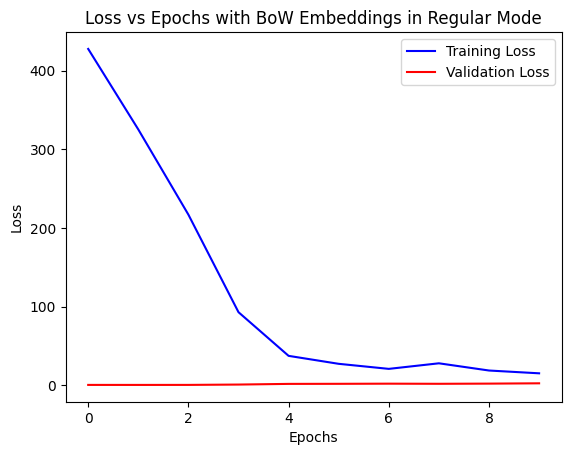

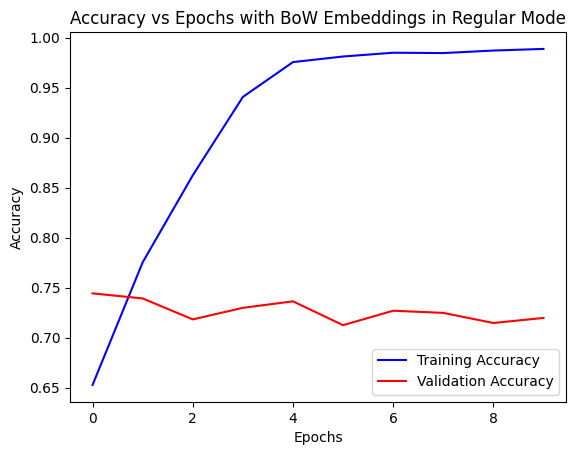

Training MLP on BERT (Dataset 1)
Epoch 1/10 | Train Loss: 312.8475 | Train Acc: 0.7749 | Val Loss: 0.3415 | Val Acc: 0.8671
Epoch 2/10 | Train Loss: 233.5962 | Train Acc: 0.8544 | Val Loss: 0.3046 | Val Acc: 0.8569
Epoch 3/10 | Train Loss: 215.5725 | Train Acc: 0.8661 | Val Loss: 0.3331 | Val Acc: 0.8562
Epoch 4/10 | Train Loss: 200.9634 | Train Acc: 0.8786 | Val Loss: 0.3002 | Val Acc: 0.8764
Epoch 5/10 | Train Loss: 184.3119 | Train Acc: 0.8871 | Val Loss: 0.3075 | Val Acc: 0.8663
Epoch 6/10 | Train Loss: 169.2217 | Train Acc: 0.8943 | Val Loss: 0.3200 | Val Acc: 0.8707
Epoch 7/10 | Train Loss: 147.4106 | Train Acc: 0.9099 | Val Loss: 0.4034 | Val Acc: 0.8699
Epoch 8/10 | Train Loss: 134.4638 | Train Acc: 0.9198 | Val Loss: 0.3415 | Val Acc: 0.8627
Epoch 9/10 | Train Loss: 114.7228 | Train Acc: 0.9333 | Val Loss: 0.4349 | Val Acc: 0.8671
Epoch 10/10 | Train Loss: 92.6998 | Train Acc: 0.9453 | Val Loss: 0.3861 | Val Acc: 0.8649


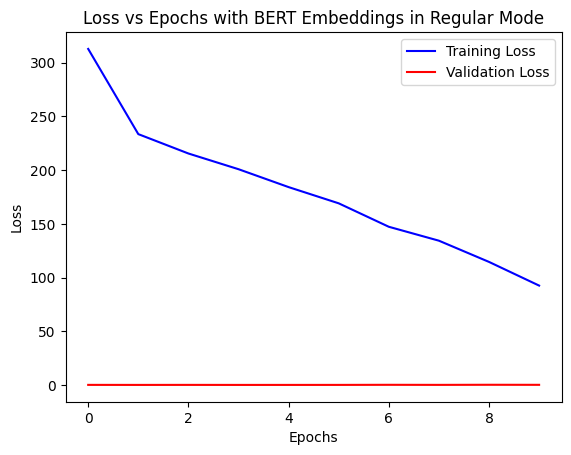

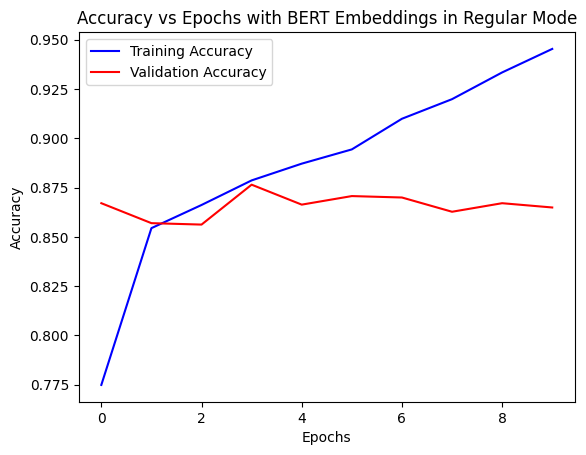

Fine-tuning MLP on BoW (IMDB)
Epoch 1/10 | Train Loss: 58.9229 | Train Acc: 0.6750 | Val Loss: 7.7723 | Val Acc: 0.6500
Epoch 2/10 | Train Loss: 51.9918 | Train Acc: 0.7375 | Val Loss: 7.4547 | Val Acc: 0.6500
Epoch 3/10 | Train Loss: 41.5825 | Train Acc: 0.7750 | Val Loss: 7.3913 | Val Acc: 0.6500
Epoch 4/10 | Train Loss: 34.0467 | Train Acc: 0.7750 | Val Loss: 7.4121 | Val Acc: 0.6500
Epoch 5/10 | Train Loss: 26.3395 | Train Acc: 0.7875 | Val Loss: 7.4189 | Val Acc: 0.7000
Epoch 6/10 | Train Loss: 19.2902 | Train Acc: 0.8250 | Val Loss: 7.4152 | Val Acc: 0.7000
Epoch 7/10 | Train Loss: 13.9065 | Train Acc: 0.8375 | Val Loss: 7.4950 | Val Acc: 0.6500
Epoch 8/10 | Train Loss: 8.5670 | Train Acc: 0.8625 | Val Loss: 7.5522 | Val Acc: 0.6500
Epoch 9/10 | Train Loss: 6.9588 | Train Acc: 0.9125 | Val Loss: 7.6291 | Val Acc: 0.6500
Epoch 10/10 | Train Loss: 6.3633 | Train Acc: 0.9375 | Val Loss: 7.6993 | Val Acc: 0.6500


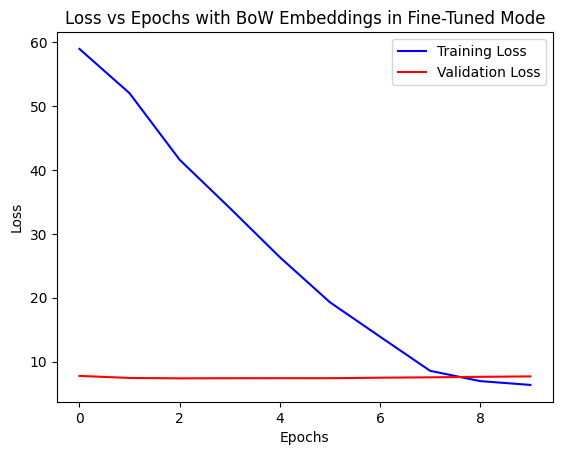

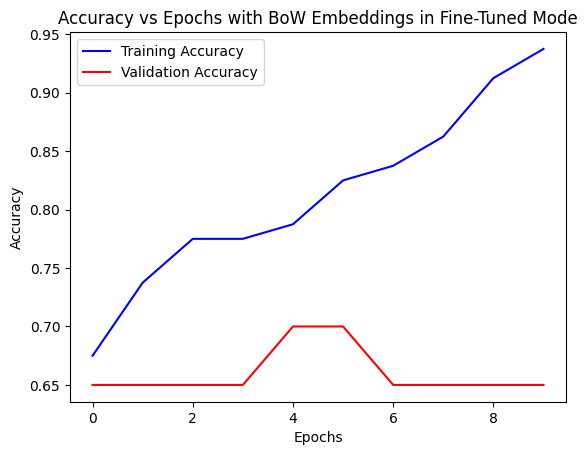

Fine-tuning MLP on BERT (IMDB)
Epoch 1/10 | Train Loss: 2.6566 | Train Acc: 0.8875 | Val Loss: 0.3357 | Val Acc: 0.9500
Epoch 2/10 | Train Loss: 1.9514 | Train Acc: 0.9000 | Val Loss: 0.2885 | Val Acc: 0.9000
Epoch 3/10 | Train Loss: 1.7094 | Train Acc: 0.9375 | Val Loss: 0.2674 | Val Acc: 0.9000
Epoch 4/10 | Train Loss: 1.5270 | Train Acc: 0.9500 | Val Loss: 0.2624 | Val Acc: 0.9000
Epoch 5/10 | Train Loss: 1.3611 | Train Acc: 0.9500 | Val Loss: 0.2642 | Val Acc: 0.9000
Epoch 6/10 | Train Loss: 1.2157 | Train Acc: 0.9750 | Val Loss: 0.2675 | Val Acc: 0.9000
Epoch 7/10 | Train Loss: 1.0827 | Train Acc: 0.9750 | Val Loss: 0.2762 | Val Acc: 0.9000
Epoch 8/10 | Train Loss: 0.9533 | Train Acc: 0.9875 | Val Loss: 0.2849 | Val Acc: 0.9000
Epoch 9/10 | Train Loss: 0.8517 | Train Acc: 0.9875 | Val Loss: 0.3027 | Val Acc: 0.9000
Epoch 10/10 | Train Loss: 0.7724 | Train Acc: 0.9875 | Val Loss: 0.3087 | Val Acc: 0.9000


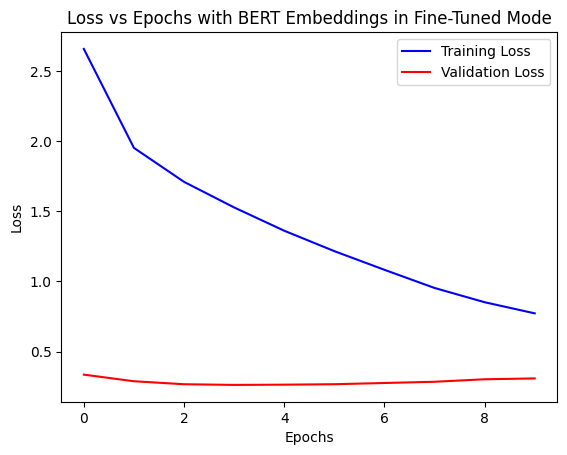

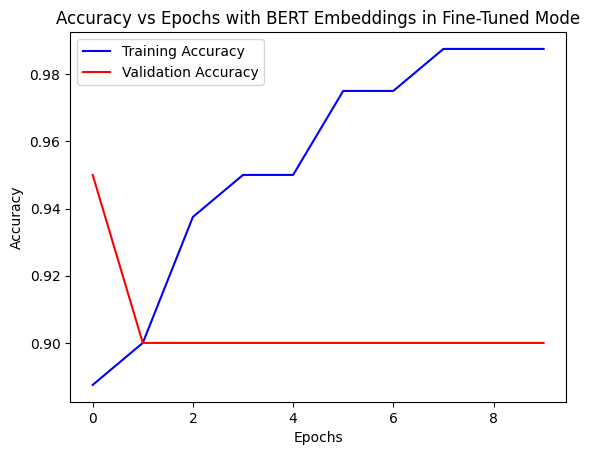

Saved final models


In [12]:
pretrain_lr = 0.001  
finetune_lr = 0.0001  

optimizer_bow = optim.Adam(model_bow.parameters(), lr=pretrain_lr)
optimizer_bert = optim.Adam(model_bert.parameters(), lr=pretrain_lr)

print("Training MLP on BoW (Dataset 1)")
train(model_bow, optimizer_bow, train_d1_bow_loader, val_d1_bow_loader, epochs=10, emb='BoW', mode='Regular', writer=writer)

print("Training MLP on BERT (Dataset 1)")
train(model_bert, optimizer_bert, train_d1_bert_loader, val_d1_bert_loader, epochs=10, emb='BERT', mode='Regular', writer=writer)

torch.save(model_bow.state_dict(), "best_model_bow.pt")
torch.save(model_bert.state_dict(), "best_model_bert.pt")

model_bow.load_state_dict(torch.load("best_model_bow.pt", weights_only=True))
model_bert.load_state_dict(torch.load("best_model_bert.pt", weights_only=True))

optimizer_bow = optim.Adam(model_bow.parameters(), lr=finetune_lr)
optimizer_bert = optim.Adam(model_bert.parameters(), lr=finetune_lr)

print("Fine-tuning MLP on BoW (IMDB)")
train(model_bow, optimizer_bow, train_d2_bow_loader, val_d2_bow_loader, epochs=10, emb='BoW', mode='Fine-Tuned', writer=writer)

print("Fine-tuning MLP on BERT (IMDB)")
train(model_bert, optimizer_bert, train_d2_bert_loader, val_d2_bert_loader, epochs=10, emb='BERT', mode='Fine-Tuned', writer=writer)

torch.save(model_bow.state_dict(), "final_model_bow.pt")
torch.save(model_bert.state_dict(), "final_model_bert.pt")

print("Saved final models")

IMDB Validation Results (BoW Model): Accuracy = 0.6500, Loss = 7.6993
IMDB Validation Results (BERT Model): Accuracy = 0.9000, Loss = 0.3087


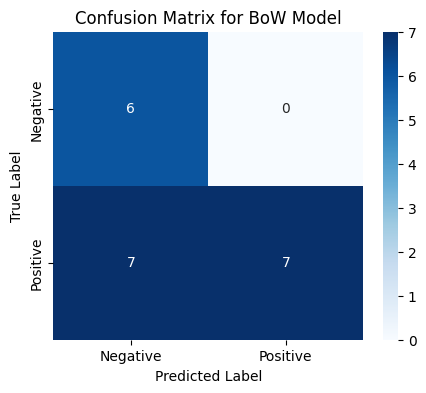

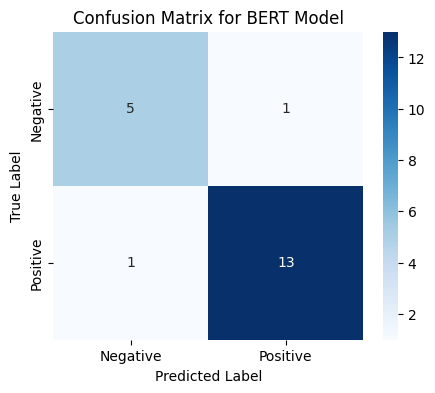

In [13]:
model_bow.load_state_dict(torch.load("final_model_bow.pt", weights_only=True))
model_bert.load_state_dict(torch.load("final_model_bert.pt", weights_only=True))

bow_imdb_val_acc, bow_imdb_val_loss = evaluate(model_bow, val_d2_bow_loader)
bert_imdb_val_acc, bert_imdb_val_loss = evaluate(model_bert, val_d2_bert_loader)

print(f"IMDB Validation Results (BoW Model): Accuracy = {bow_imdb_val_acc:.4f}, Loss = {bow_imdb_val_loss:.4f}")
print(f"IMDB Validation Results (BERT Model): Accuracy = {bert_imdb_val_acc:.4f}, Loss = {bert_imdb_val_loss:.4f}")

bow_cm, bow_y_true, bow_y_pred = evaluate_with_confusion_matrix(model_bow, val_d2_bow_loader)
bert_cm, bert_y_true, bert_y_pred = evaluate_with_confusion_matrix(model_bert, val_d2_bert_loader)

plot_confusion_matrix(bow_cm, "BoW Model")
plot_confusion_matrix(bert_cm, "BERT Model")

In [14]:
%load_ext tensorboard
%tensorboard --logdir runs

<IPython.core.display.Javascript object>